# Contrail detection

Using pre-trained model to detect contrail on a local dataset from OpenContrails

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import data
from contrail import ContrailModel

import os
import rasterio

torch.set_grad_enabled(False)


/home/hugo/miniconda3/envs/resunet_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load MTG images

In [ ]:
# Directory containing GeoTIFF images
geotiff_dir = "data/mtg"

# List to store loaded images and their filenames
geotiff_images = []
geotiff_filenames = []

# Load GeoTIFF images
for filename in os.listdir(geotiff_dir):
    if filename.endswith(".tif"):
        filepath = os.path.join(geotiff_dir, filename)
        with rasterio.open(filepath) as src:
            geotiff_images.append(src.read())
            geotiff_filenames.append(filename)

print(f"Loaded {len(geotiff_images)} GeoTIFF images.")

Loaded 34 GeoTIFF images.


In [3]:
def transfo_mtg(image):
    transf = -image.transpose(1, 2, 0).sum(axis=2)
    transf = (transf - transf.min()) / (transf.max() - transf.min())
    return transf

In [4]:
# Apply transfo_mtg to all images in geotiff_images
transformed_images = [transfo_mtg(image) for image in geotiff_images]

print(f"Transformed {len(transformed_images)} GeoTIFF images.")

AttributeError: 'tuple' object has no attribute 'transpose'

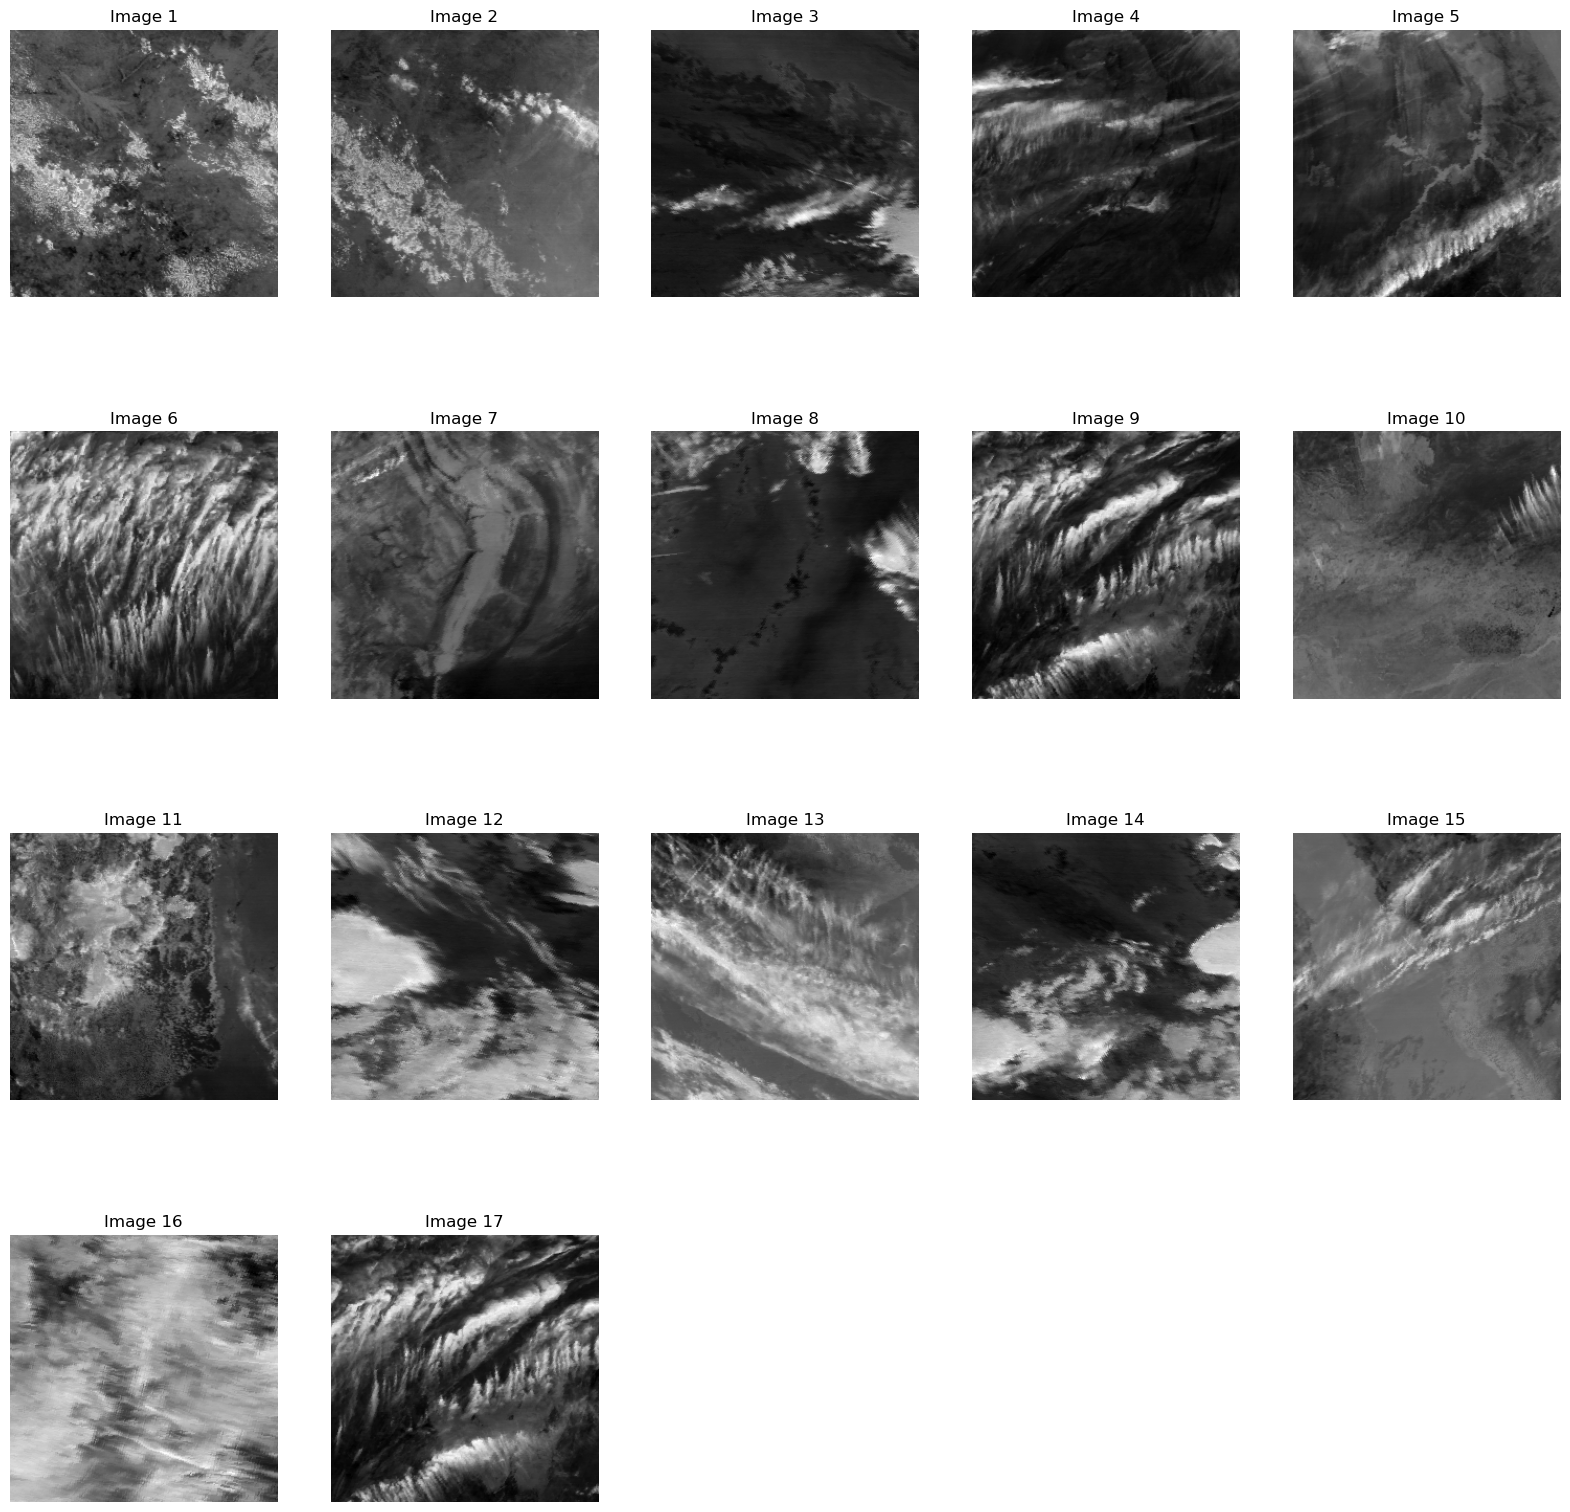

In [6]:
plt.figure(figsize=(20, 20))
for i, image in enumerate(transformed_images):
    plt.subplot(4, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Image {i+1}')
    plt.axis('off')
plt.show()

### Displaying a model segmentation
Use pre-trained model. To do so, download the wanted pre-trained model in a local folder named *models* localised in the *data* folder from the link https://surfdrive.surf.nl/files/index.php/s/n1b0L2qfu2PZ6d3

In [6]:
path_to_model = "data/models/google_fewshot_3000-dice-30minute.torch" # Choose your model
model = ContrailModel("UNet", in_channels=1, out_classes=1)
model.load_state_dict(torch.load(path_to_model))

<All keys matched successfully>

Then load the data. Choose the number of images you want to load by specifying it in the variable *batch_size*

In [7]:
# train_dataset, test_dataset = data.own_dataset(train=False)
test_dataset = [(np.expand_dims(image, axis=0),np.zeros_like(np.expand_dims(image, axis=0))) for image in transformed_images]

test_dataloader = DataLoader(
    test_dataset,
    batch_size=17,
    num_workers=0,
    shuffle=True,
)

batch = next(iter(test_dataloader))
images = batch[0]
masks = batch[1]

Then evaluate the model and compute its predictions

In [8]:
model.eval()
logits1 = model(batch[0])
pred1 = logits1.sigmoid()

Finally, plot the image, its mask and the prediction made by the model in order to compare visually

/tmp/ipykernel_684370/3337332179.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  "Image": np.array(image),
/tmp/ipykernel_684370/3337332179.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  "Labeled": np.array(mask),
/tmp/ipykernel_684370/3337332179.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://

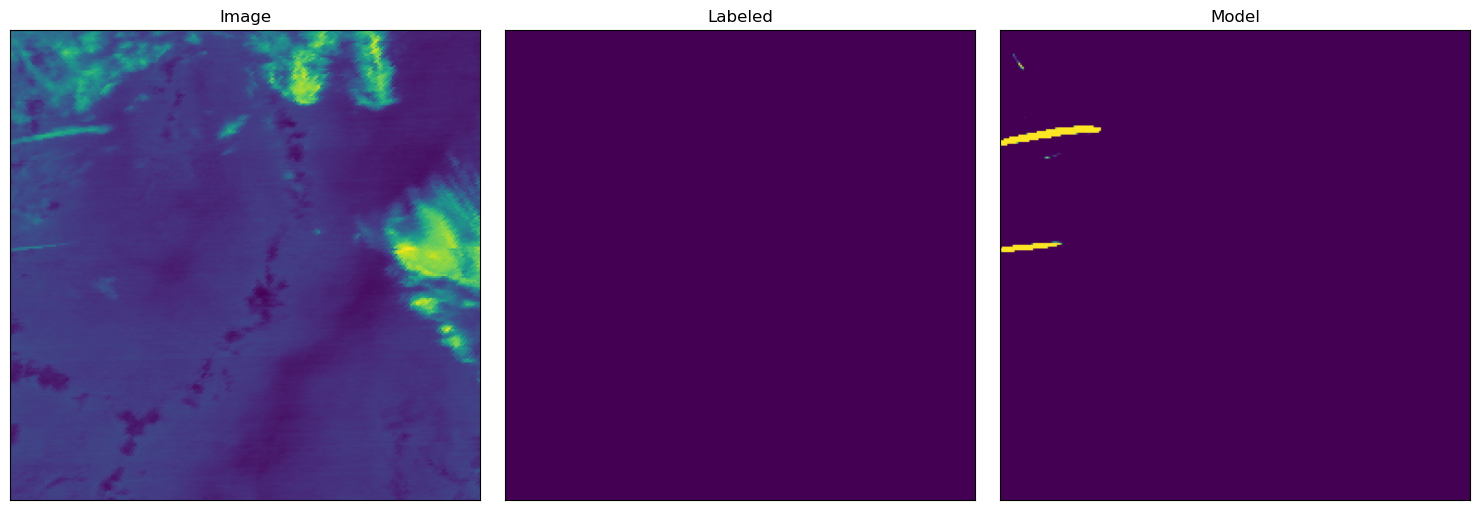

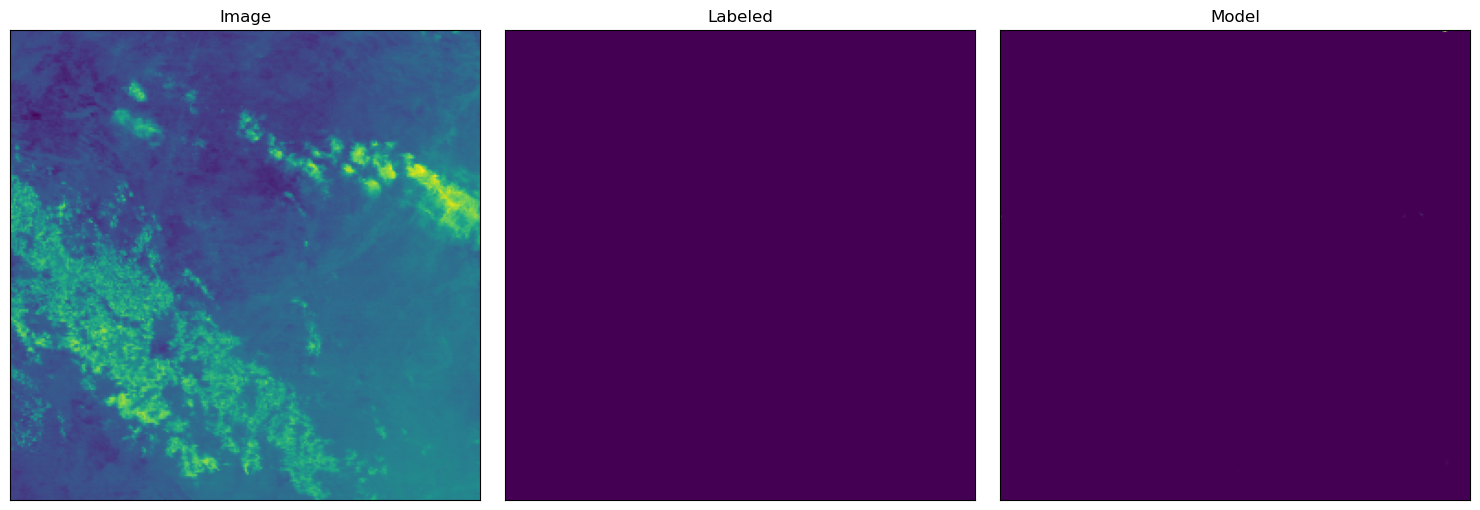

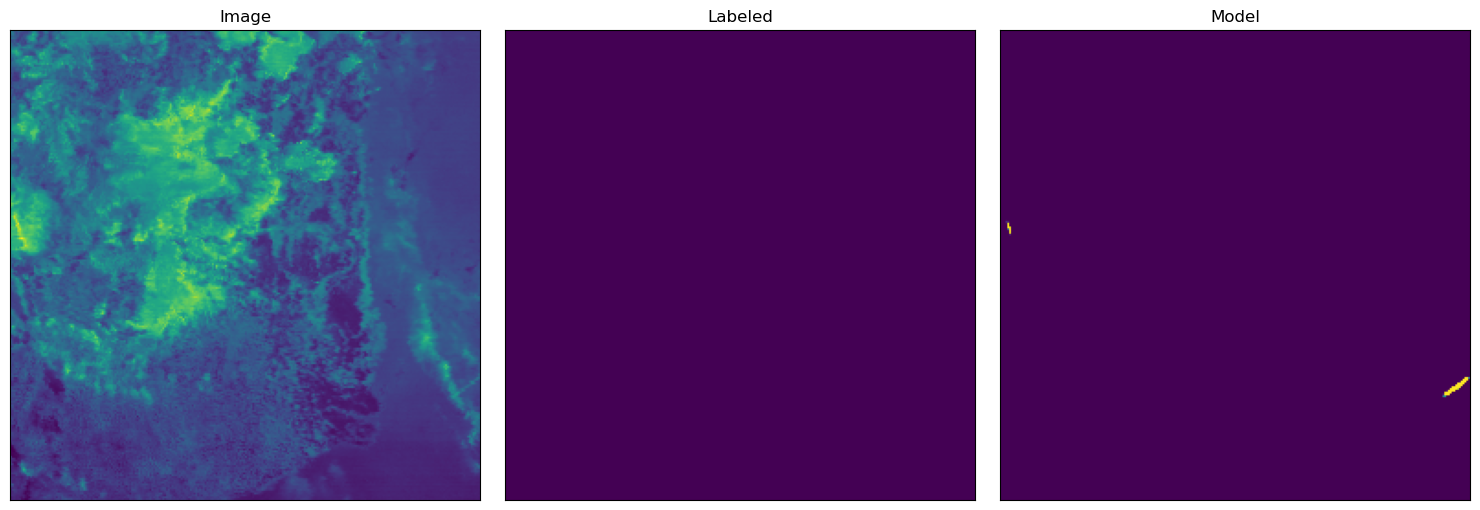

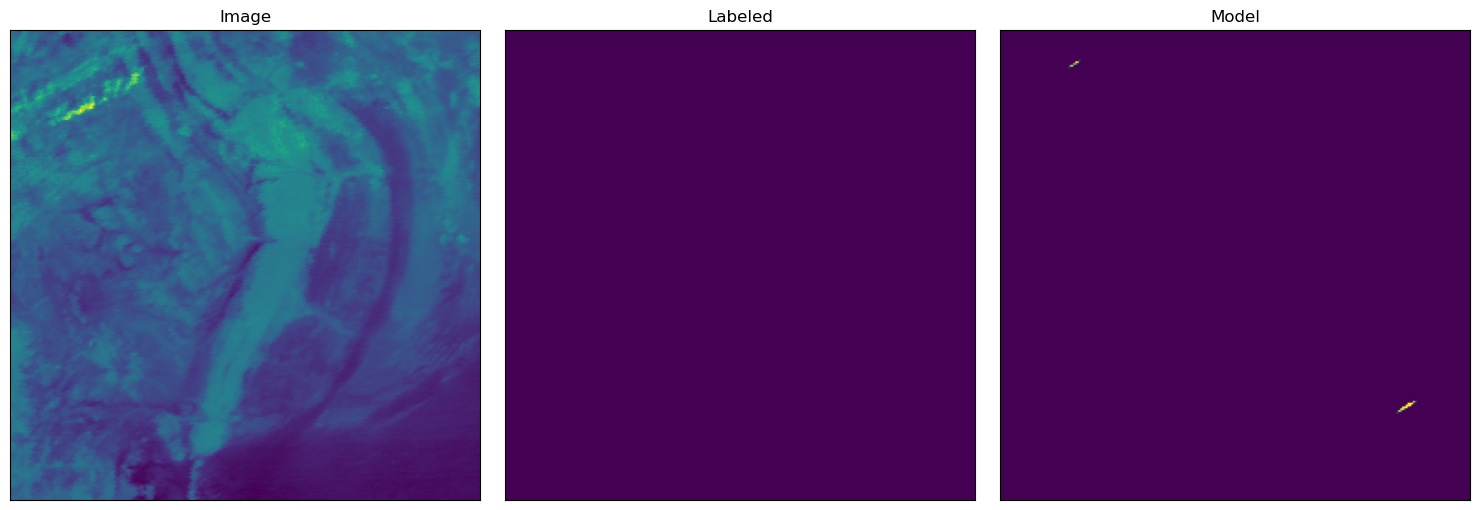

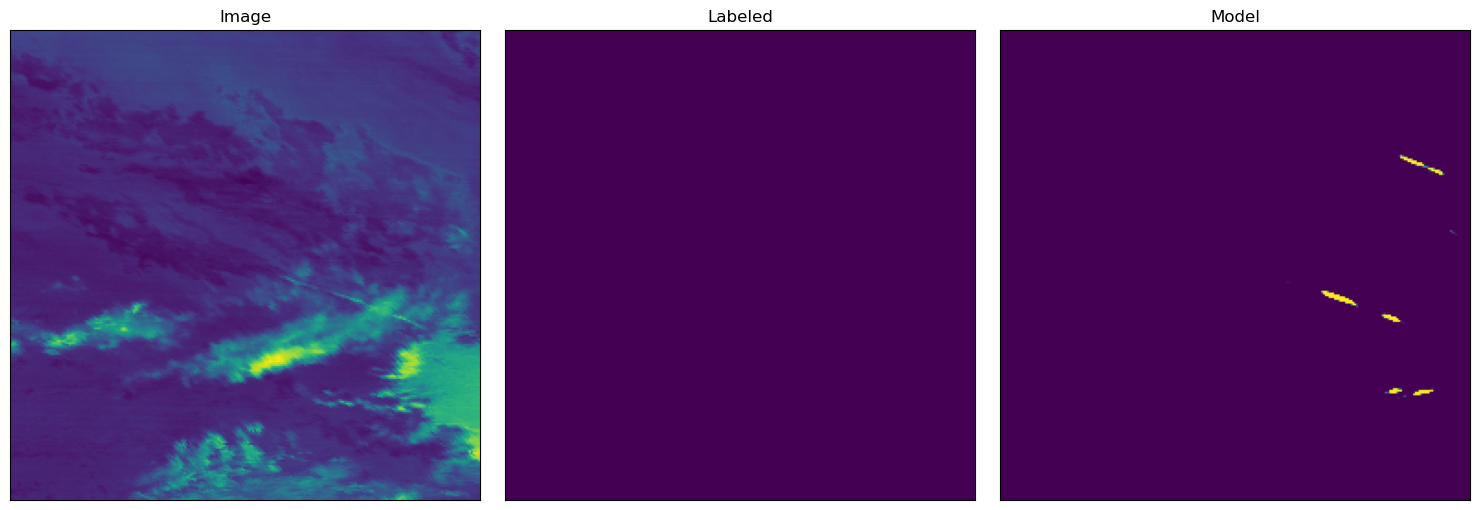

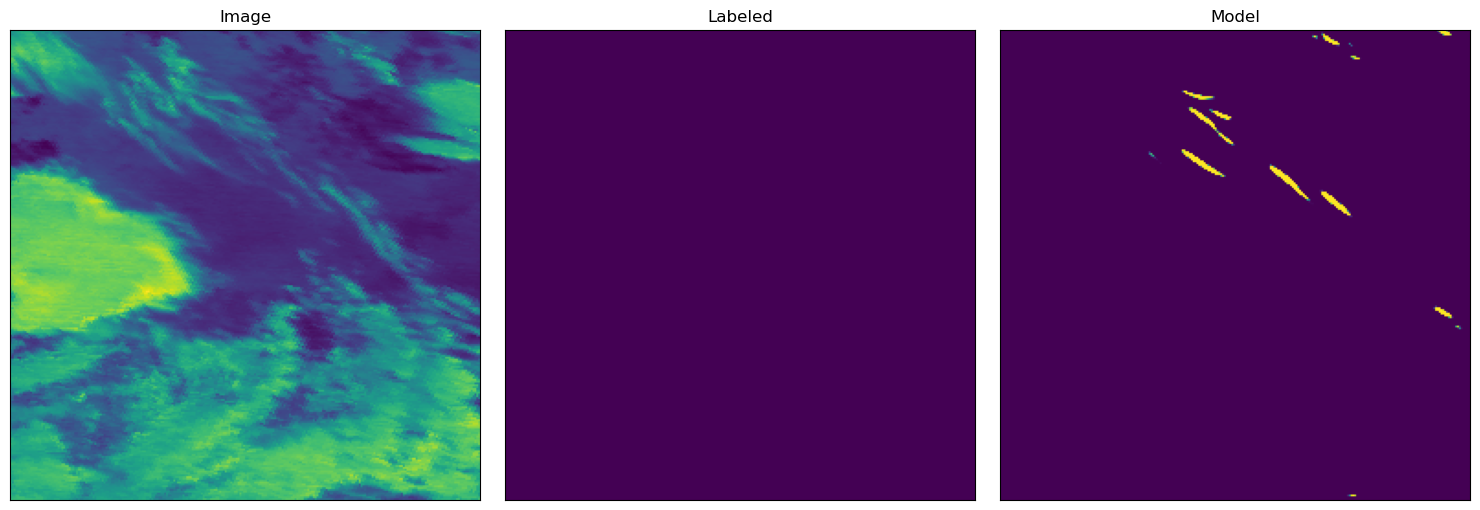

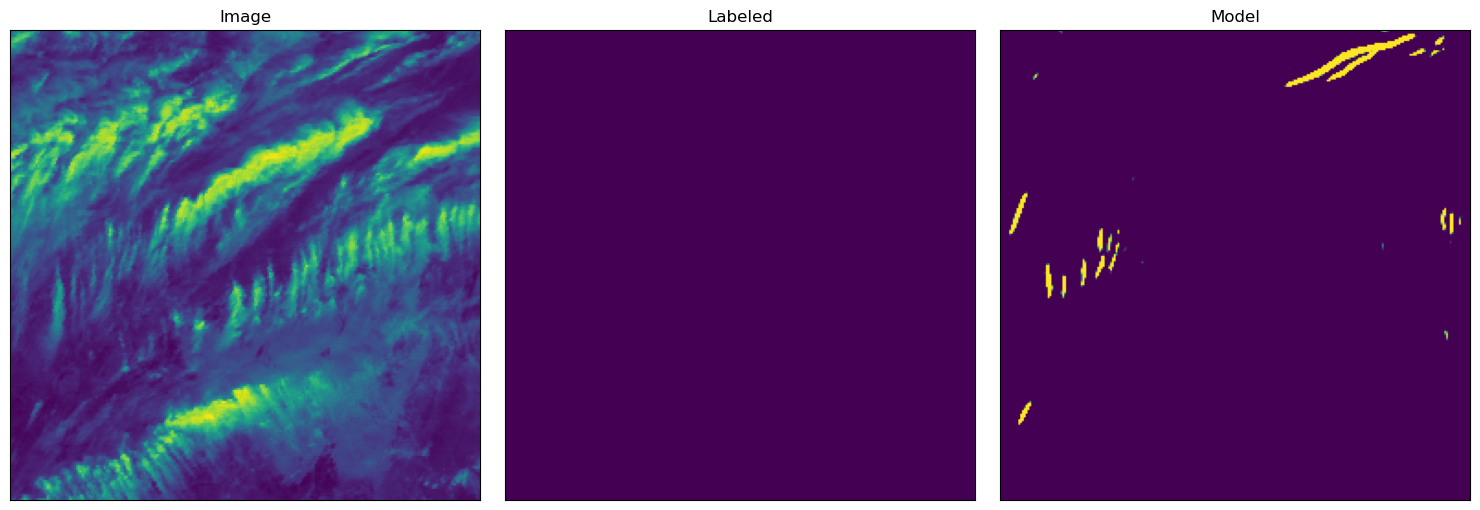

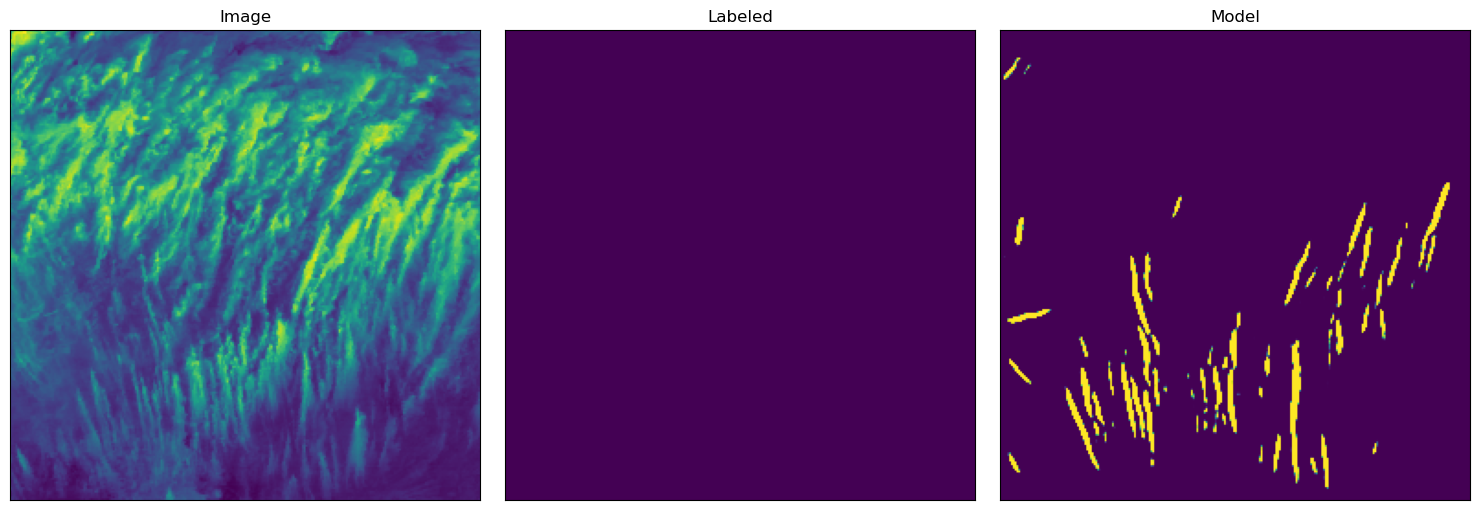

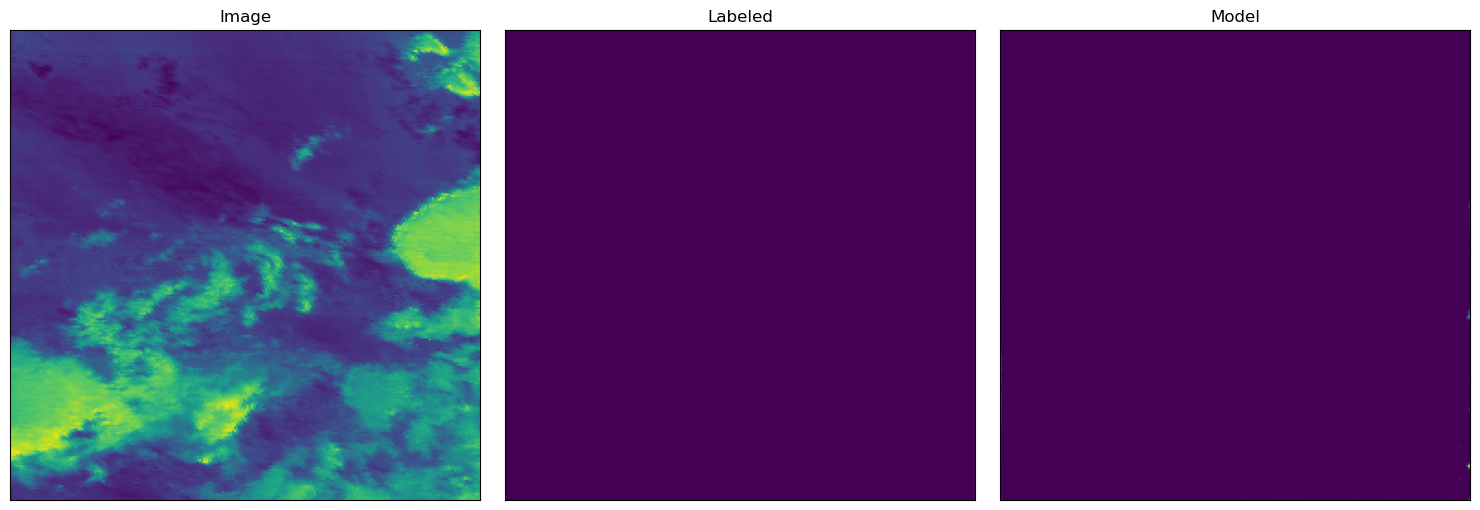

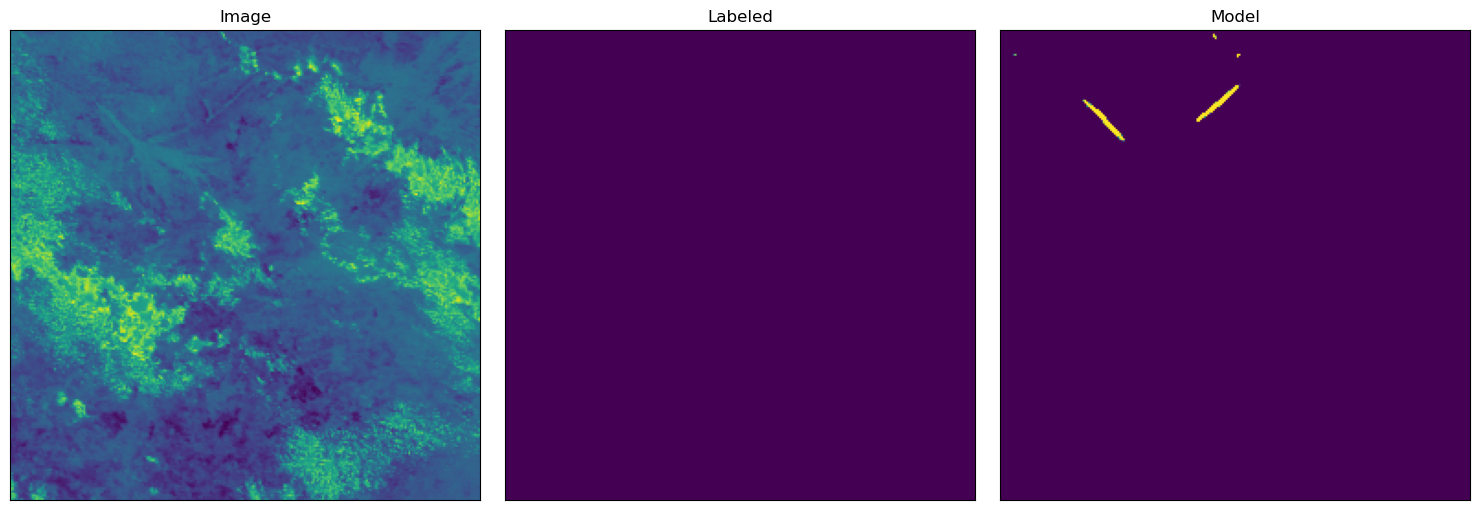

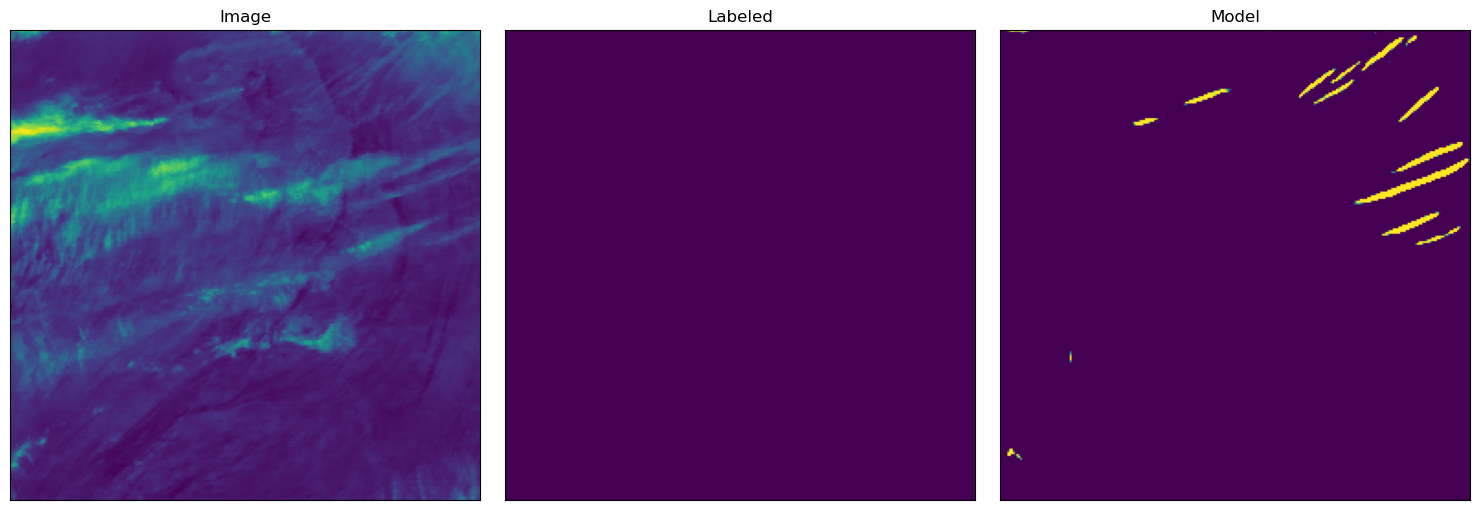

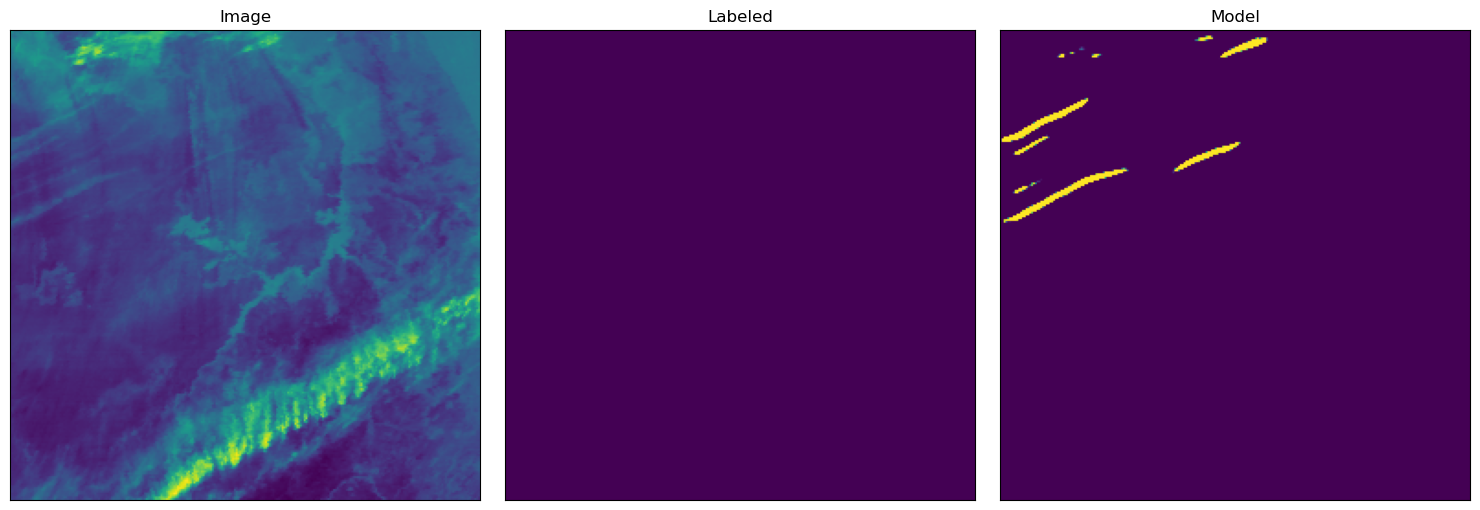

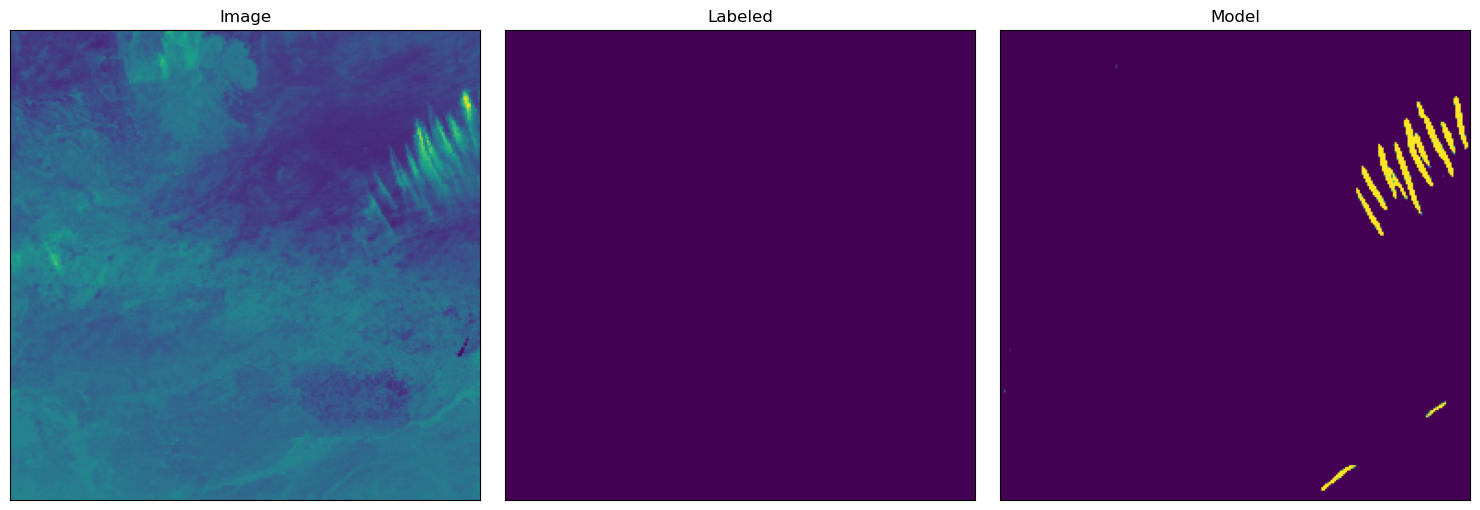

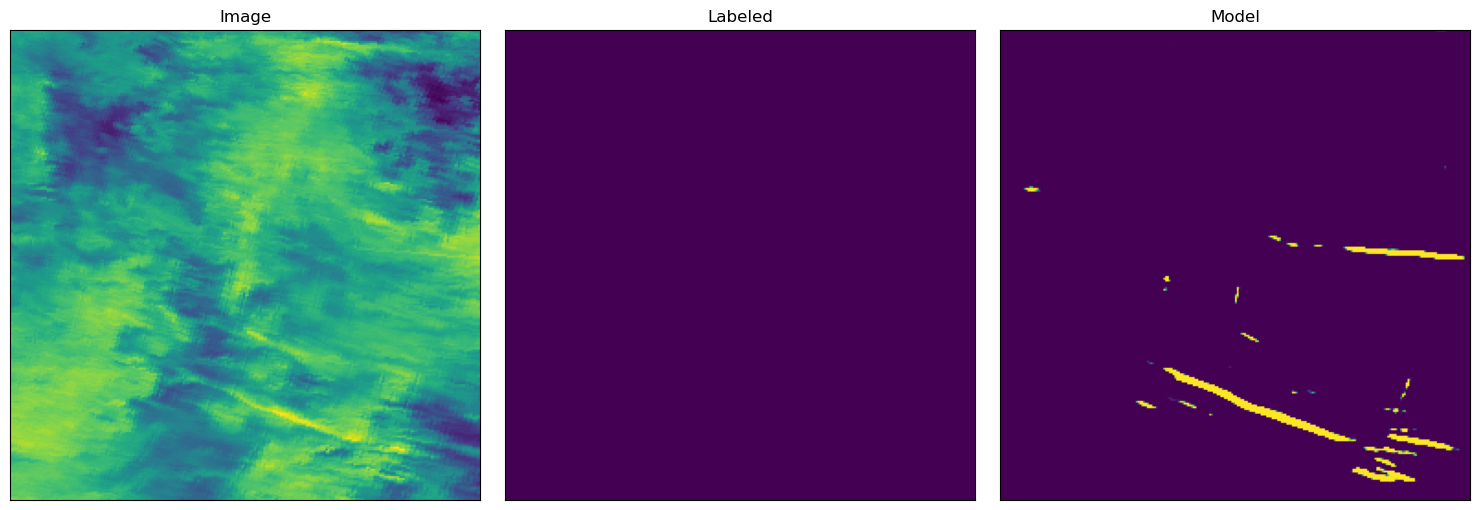

In [9]:
for i in range(len(batch[0])):
    image = batch[0][i]
    mask = batch[1][i]

    d = {
        "Image": np.array(image),
        "Labeled": np.array(mask),
        "model": np.array(pred1[i]),
    }

    data.visualize(**d)

In [5]:
pred1

NameError: name 'pred1' is not defined

### Infering the model
Now, the goal is to evaluate the perfomance of the model according to 2 types of per-pixel metrics: the F1 score and the AUC score.
A larger batch (1000 images) is used to infer the model in order to get a more reliable value. The inference is calculated on the whole batch.

In [10]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1000,
    num_workers=0,
    shuffle=True,
)

batch = next(iter(test_dataloader))

F1 score:

In [ ]:
with torch.no_grad():
    model.eval()
    logits = model(batch[0])
    predict = logits.sigmoid()

    # Binarize predictions for F1 score calculation
    predict = (predict > 0.5).float()
    target = batch[1]

    # Calculate Precision and Recall
    true_positives = torch.sum(predict * target)
    predicted_positives = torch.sum(predict)
    actual_positives = torch.sum(target)
    precision = true_positives / (predicted_positives + 1e-8)
    recall = true_positives / (actual_positives + 1e-8)

    # Calculate F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-8)
    print('F1 score:', "\t", round(f1_score.item(), 3))

F1 score: 	 0.0


AUC score (with the ROC curve):

/home/hugo/miniconda3/envs/resunet_env/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


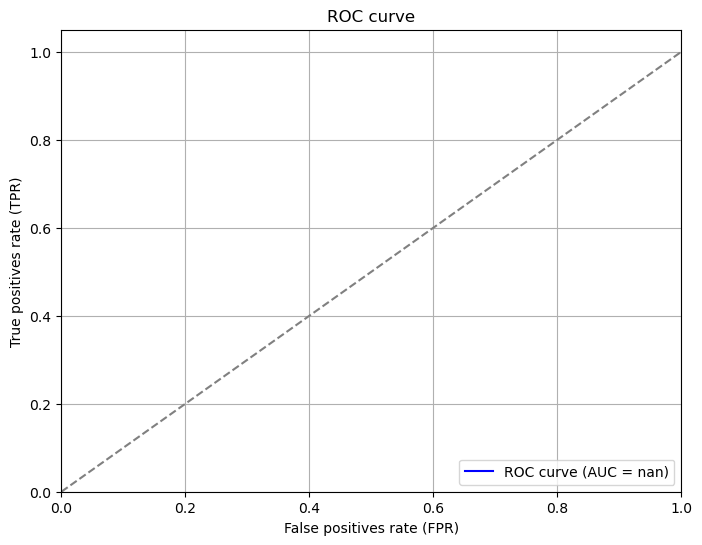

In [ ]:
with torch.no_grad():
    logits = model(batch[0])
    probabilities = logits.sigmoid().cpu().numpy()

# Flatten 2D matrices into 1D arrays for pixel-wise ROC calculation
target_flatten = batch[1].cpu().numpy().flatten()
predict_flatten = probabilities.flatten()

# Binarize ground truth labels
target_flatten = (target_flatten > 0.5).astype(int)

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(target_flatten, predict_flatten)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with the AUC score (area under the curve)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Ligne aléatoire
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positives rate (FPR)')
plt.ylabel('True positives rate (TPR)')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()